# Table of Contents
 <p><div class="lev1 toc-item"><a href="#In-silico-qPCR-for-quality-control,-Figure-5" data-toc-modified-id="In-silico-qPCR-for-quality-control,-Figure-5-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><em>In silico</em> qPCR for quality control, Figure 5</a></div><div class="lev1 toc-item"><a href="#Quality-Control-on-the-hypoxia-response-and-the-hif-1-direct-target-predictions" data-toc-modified-id="Quality-Control-on-the-hypoxia-response-and-the-hif-1-direct-target-predictions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Quality Control on the hypoxia response and the hif-1 direct target predictions</a></div>

In this notebook, we present some basic sanity checks that our RNA-seq worked and that the data is picking up on the right signals. It's a fairly short notebook. 

In [ ]:
# important stuff:
import os
import pandas as pd
import numpy as np

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan
import gvars
import genpy

# stats
from scipy import stats as sts

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}

sns.set(style='dark', context='notebook', font='sans-serif')

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [ ]:
tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')

# import the code <--> genotype mapping and other useful variables
genvar = gvars.genvars()

tf_df = pd.read_csv('../input/tf_list.csv')
hypoxia_gold = pd.read_csv('../input/hypoxia_gold_standard.csv', sep=',')
hypoxia_direct_targets = pd.read_csv('../output/medium_confidence_hypoxia_targets_candidates.csv')
hypoxia_response = pd.read_csv('../output/hypoxia_response.csv')

In [ ]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')
thomas.add_single_mutant(single_mutants)
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# load all the beta values for each genotype:
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)
thomas.filter_data()

In [ ]:
frames = []
for key, df in thomas.beta.items():
    df['code'] = key
    df['genotype'] = genvar.fancy_mapping[key]
    frames += [df]
tidy = pd.concat(frames)
# drop the fog-2 dataset
tidy = tidy[tidy.code != 'g']

# *In silico* qPCR for quality control, Figure 5

*egl-9*, *rhy-1* and *nhr-57* are known to be HIF-1 responsive. Let's see if our RNA-seq experiment can recapitulate these known interactions.

For ease of viewing, we will plot these results as bar-charts, to simulate actual qPCR results. But we must be clear: This is **not** qPCR data! It's RNA-seq.

First, we must select what genes we will use for our quality check. I would like to take a look at *rhy-1*, *egl-9* and *nhr-57*. All of these are known to be up-regulated during hypoxia. However, a small issue is that *egl-9* has multiple isoforms. Now, for full disclosure, I should reveal that not all isoforms are differentially expressed. A couple are, and their patterns match. So, I have made the somewhat controversial choice of showing only a single isoform, F22E12.4c in the paper as *egl-9*. Here is how we made figure 5 in our paper.

In [ ]:
x = ['WBGene00012324', 'F22E12.4c',
     'WBGene00003647', 'WBGene00002248']

find_x = ((tidy.ens_gene.isin(x)) | (tidy.target_id.isin(x)))
plot_df = tidy[find_x].copy()

x_sort = {'WBGene00012324': 1, 'WBGene00001178': 2,
     'WBGene00003647': 3, 'WBGene00002248': 4}

plot_df['order'] = plot_df.ens_gene.map(x_sort)
plot_df.sort_values('order', inplace=True)
plot_df.reset_index(inplace=True)  

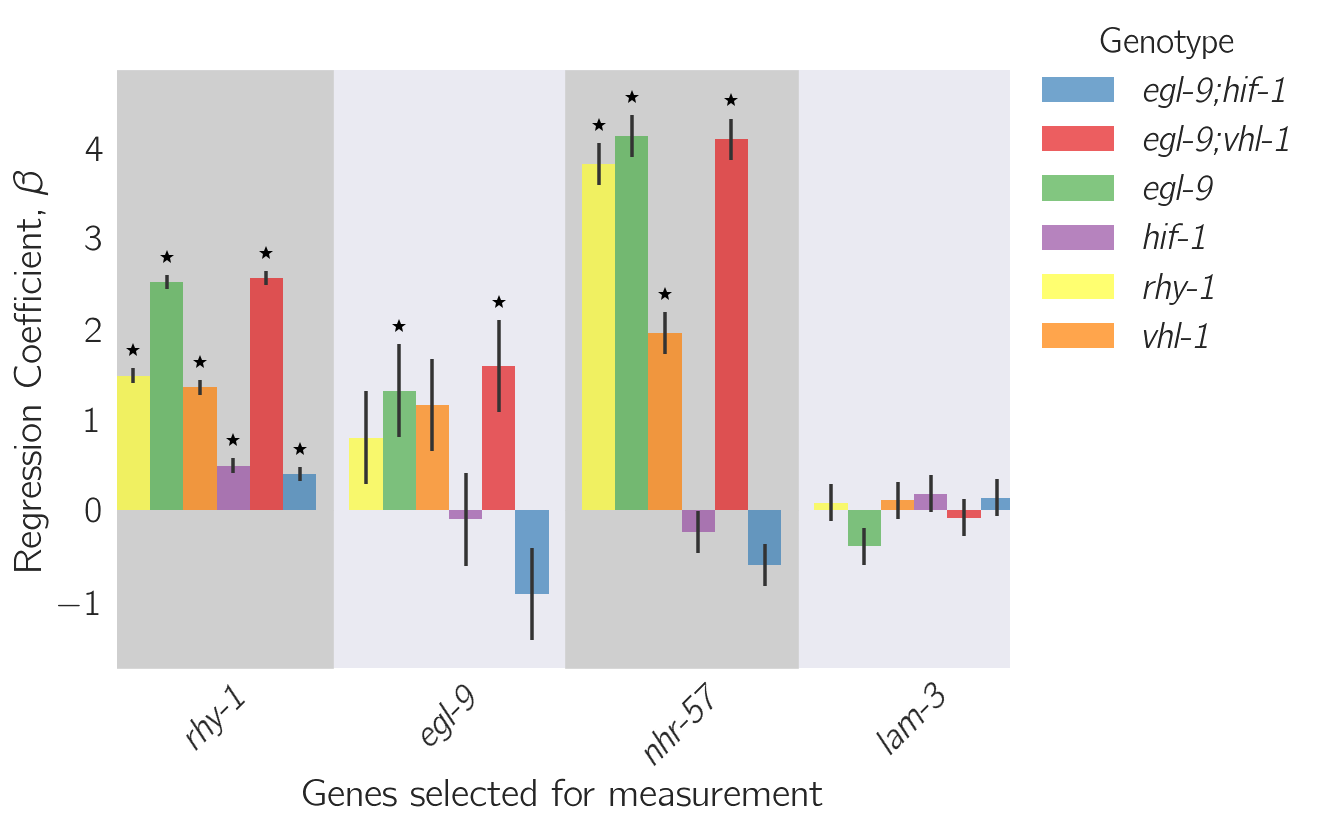

In [ ]:
genpy.qPCR_plot(plot_df, genvar.plot_order, genvar.plot_color, clustering='genotype', plotting_group='ens_gene', rotation=45)
plt.xlabel(r'Genes selected for measurement', fontsize=20)
save = '../output/hif1_qualitycontrol.svg'
plt.savefig(save, bbox_inches='tight')

It looks like we are able to recapitulate most of the known interactions between these reporters and HIF-1 levels. There are no contradicting results, although the *egl-9* levels don't quite reach statistical significance. For completeness, below I show ALL the *egl-9* isoforms. 

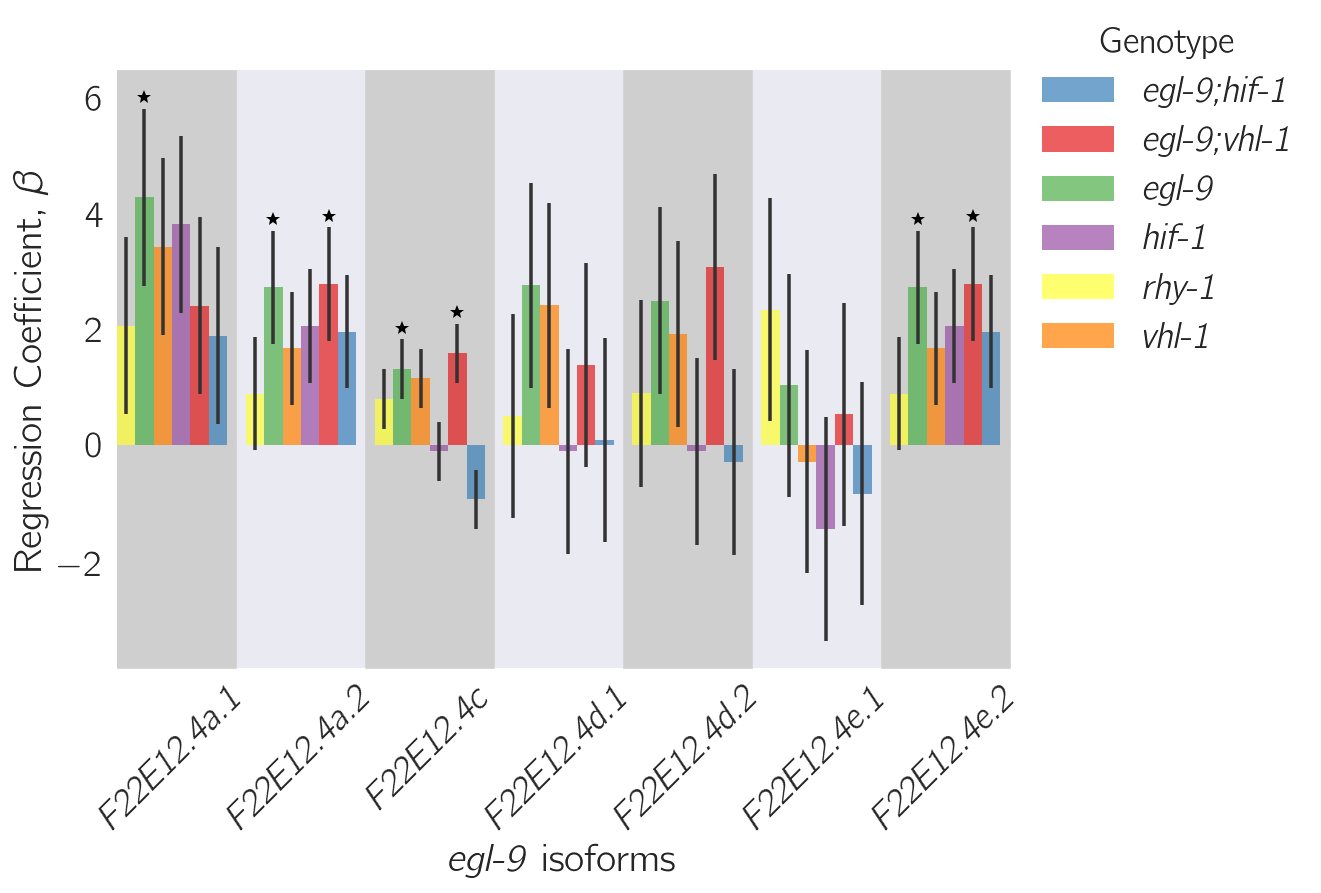

In [ ]:
x = ['WBGene00001178']

find_x = tidy.ens_gene.isin(x)
plot_df = tidy[find_x].copy()

x_sort = {}
for i, target in enumerate(plot_df.target_id.unique()):
    x_sort[target] = i + 1

plot_df['order'] = plot_df.target_id.map(x_sort)
plot_df.sort_values('order', inplace=True)
plot_df.reset_index(inplace=True)  

genpy.qPCR_plot(plot_df, genvar.plot_order, genvar.plot_color, clustering='genotype', plotting_group='target_id', rotation=45)
plt.xlabel(r'\emph{egl-9} isoforms', fontsize=20)



# Quality Control on the hypoxia response and the hif-1 direct target predictions

That's one way to check the quality of our RNA-seq. Another way is to look for what genes are D.E. in our hypoxia dataset. We will test the most conservative guess for the hypoxia response, and the predicted hypoxia targets using a hypergeometric test. 

In [ ]:
def test_significance(df, gold=hypoxia_gold):
    ind = df.ens_gene.isin(hypoxia_gold.WBIDS)
    found = df[ind].ens_gene.unique()
    sig = len(df)  # number of genes that we picked
    ntotal = len(thomas.beta['a'])  # total genes measured
    pval = sts.hypergeom.sf(len(found), ntotal,
                            len(hypoxia_gold), sig)    
    if pval < 10**-3:
        print('This result is statistically significant' +\
              ' with a p-value of {0:.2g} using a hypergeometric test. '.format(pval) +\
              'You found {0} gold standard genes!'.format(len(found)))
    else:
        print(pval)

Hypoxia response (conservative guess):

In [ ]:
test_significance(hypoxia_response)

This result is statistically significant with a p-value of 2.1e-10 using a hypergeometric test. You found 8 gold standard genes!


Hypoxia predicted targets:

In [ ]:
test_significance(hypoxia_direct_targets)

This result is statistically significant with a p-value of 7.5e-11 using a hypergeometric test. You found 7 gold standard genes!


Both datasets are enriched for known hypoxic response genes!